手法の補足
- データ期間: 2025/01/01 00:00 - 2025/02/01 00:00 1分足
  - Tardisから取得し，1分足にするコードセルがありますが，これで作成したデータを共有しているので，その章のセルは実行不要です．
  - 精度向上のために，今後はそもそも1分足ではなく秒足やtickを使う可能性が高い．
- 取引戦略
  - `pred_steps=10` 分ごとに，1分先の板情報予測を自己回帰的に10回繰り返して10分先まで予測
  - 現在価格からの変化率が往復手数料率(2*0.055%)を上回るなら，成行注文
  - すでに買い(売り)ポジションを持っており，買い(売り)予測が続く場合は何もしない (ポジション保持)
- 取引はすべて成行で行う．
  - ⚠️指値のほうが手数料は安いが，上昇(下落)予測時に現在価格の少し下(上)に指値を出す戦略だと，実際には刺さらず機会損失になることがかなり多いため，成行を前提とし，モデルの精度を上げて上から殴る方針．

💡現在の改良案
- 📊データ関連
  - 🌟秒足・Tickデータを使う
    - そもそも板情報は一瞬の動きが重要なので．
    - ここで使うモデルは観測が一定時間間隔で行われる前提であり，tickデータのような不規則間隔への対応は工夫が必要．
      - 間隔自体もポアソン過程などで確率モデル化するアイディアはある．
  - 🌟Imbalance (価格帯ごとの合計数量のヒストグラム) を使う
  - データスケーリング方法
    - 現在 DeepLOB (Zhang+, 2019) と同様に，price/amountそれぞれ直近一定期間のμ,σで標準化している．
    - しかしamountに関しては，本来取る範囲が正であることと，Bybitでは注文数量制限(1度の指値注文で155BTCなど)があるので，それを目安に1000で除算するなどのほうが良いかも．データ間でスケールも統一される．
  - 板のスナップショットではなく注文データを使う (市場参加者の行動モデル)
    - 本来市場参加者の指値・成行注文が板のスナップショットを形成する．
    - これらの注文データを予測できれば，理論上は価格予測も可能なうえ，市場参加者のモデル化という意味も持つ．
    - Tardisからは `data_types` に指値なら `incremental_book_L2`，成行なら `trades` を指定してDL可能
    - 確率モデルとして実装するには分布設定(制約)がかなり複雑．
- 🧠モデル関連
  - ニューラルネットワークモデルの改良
    - 現在はシンプルな中間層2層のMLP (+dropoutによるモンテカルロサンプリング)
    - 1時刻に観測するデータはその時刻の板スナップショット (10レベルで40変数) のベクトル
    - 内部状態として複数の潜在変数ベクトル (つまり行列) で分布サンプルを表現している
      - これを効果的に扱えるようにネットワーク構造を工夫する余地あり (Transformerなど)
  - ハイパーパラメータ調整について
    - このモデルは良いパラメータを見つけられれば単調に増え続けるので，全データ期間で最適化したハイパラは今後も通用する可能性は高い．
    - これまでのところ，Optunaで最適化したが，手数料ありでも安定したパラメータは見つかっていない．

In [1]:
import tardis, backtest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import optuna, joblib, gc
import torch, time
import torch.nn.functional as F
from torch import nn, Tensor

LOB_DEPTH = 10  # 使用する板の深さ
B1_INDEX = 0                # B1のインデックス
A1_INDEX = 2 * LOB_DEPTH    # A1のインデックス
FEATURES = 4 * LOB_DEPTH    # 入力変数の数
BID, ASK, STAY = 0, 1, 2    # 行動ラベル: 売，買，何もしない
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# データ取得・1分足保存
- データ期間: 2025/01/01 00:00 - 2025/02/01 00:00
- このコードで作成したCSVを共有しているので，**この章のセルは実行しなくてOK**です(数十分かかります)．
- ⚠️精度向上のために，今後は秒足やtickデータを使う方向にシフトする予定です．

In [2]:
# Tardisからダウンロード
DATA_DIR = "./data/tardis/daily"   # Tardisデータ保存先
tardis.download_data("2025-02-01", "2025-02-27", data_types=["book_snapshot_25"], download_dir=DATA_DIR)

In [3]:
# # 1分足にダウンサンプリングして読み込み
df_ss = tardis.load_snapshots("2025-02-01", "2025-02-27", DATA_DIR, freq="1min")

loading 2025-02-27 snapshot...


In [4]:
df_ss.to_csv(f"./BTCUSDT_book_2502_1min.csv.gz")

# 1分足データ読み込み

In [5]:
df_ss = pd.read_csv(f"./BTCUSDT_book_2502_1min.csv.gz", index_col=0, parse_dates=True).ffill()
cols = (
    [f"b{i+1}"  for i in range(LOB_DEPTH)] +
    [f"bq{i+1}" for i in range(LOB_DEPTH)] +
    [f"a{i+1}"  for i in range(LOB_DEPTH)] +
    [f"aq{i+1}" for i in range(LOB_DEPTH)]
)
df_ss = df_ss[cols]

print(df_ss.index.is_monotonic_increasing)  # ✅️時刻は単調増加
print(df_ss.index.has_duplicates)           # ✅️時刻重複なし
print(df_ss.isna().sum().sum())             # ✅️欠損なし

True
False
0


In [ ]:
# df_ss

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,...,aq1,aq2,aq3,aq4,aq5,aq6,aq7,aq8,aq9,aq10
local_timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-01 00:01:00,102253.5,102253.3,102253.2,102253.1,102252.9,102252.8,102252.5,102252.3,102252.0,102251.9,...,1.266,0.001,0.002,0.071,0.038,0.582,0.428,0.052,0.001,0.003
2025-02-01 00:02:00,102267.1,102267.0,102266.7,102266.6,102266.5,102266.0,102265.9,102265.6,102265.2,102264.8,...,1.915,0.001,0.002,0.019,0.001,0.146,0.001,0.001,0.019,0.001
2025-02-01 00:03:00,102240.1,102240.0,102239.9,102239.8,102239.7,102239.6,102239.3,102239.2,102239.0,102238.9,...,0.642,0.057,0.147,0.001,0.049,0.051,0.034,0.078,0.001,0.039
2025-02-01 00:04:00,102211.1,102211.0,102210.9,102210.8,102210.6,102210.5,102210.4,102210.3,102210.1,102209.7,...,5.533,0.080,0.128,0.192,0.001,0.001,0.034,0.039,0.080,0.055
2025-02-01 00:05:00,102246.9,102246.4,102246.0,102245.6,102245.5,102245.1,102244.8,102244.1,102244.0,102243.1,...,2.068,0.001,0.001,0.001,0.038,0.001,0.001,0.001,0.006,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-27 23:56:00,84796.2,84796.0,84795.2,84794.3,84793.5,84793.4,84792.7,84792.6,84792.5,84792.4,...,3.189,0.354,0.047,0.588,0.094,0.591,0.569,0.002,0.047,0.047
2025-02-27 23:57:00,84831.5,84830.6,84830.1,84830.0,84829.8,84829.5,84829.2,84828.9,84828.1,84827.2,...,2.561,0.001,0.008,0.047,0.002,0.109,0.160,0.012,0.002,0.057
2025-02-27 23:58:00,84778.9,84778.4,84778.0,84777.0,84776.8,84776.4,84776.0,84775.8,84775.6,84775.3,...,0.019,0.002,0.002,0.012,0.002,0.002,0.002,0.001,0.032,0.104


# モデル

In [7]:
# 標準化: DeepLOB (Zhang+, 2019) ベース．サンプルごとに，価格と数量を別々に標準化 (バッチ処理にも1時刻にも対応)
class LOBScaler:
    def __init__(self, x: Tensor):              # x.shape: ((bsz), seqlen, 4*LOB_DEPTH) スケール基準データ
        self.depth = x.shape[-1] // 4
        x_ = x.contiguous().view(-1, 2*x.shape[-2], 2*self.depth)   # (bsz, 2*seqlen, 2*LOB_DEPTH) ※2次元配列の左半分(d列)をprice，右半分(d列)をamountにする
        self.price_mean  = x_[..., :self.depth].mean((1, 2), keepdim=True)      # (bsz, 1, 1)
        self.price_std   = x_[..., :self.depth].std( (1, 2), keepdim=True)      # (bsz, 1, 1)
        self.amount_mean = x_[..., self.depth:].mean((1, 2), keepdim=True)      # (bsz, 1, 1)
        self.amount_std  = x_[..., self.depth:].std( (1, 2), keepdim=True)      # (bsz, 1, 1)

    def normalize(self, x: Tensor):             # ((bsz), seqlen, 4*LOB_DEPTH)
        x_ = x.contiguous().view(-1, 2*x.shape[-2], 2*self.depth)               # (bsz, 2*seqlen, 2*LOB_DEPTH)
        price = (x_[..., :self.depth] - self.price_mean) / self.price_std       # (bsz, 2*seqlen, LOB_DEPTH)
        amount = (x_[..., self.depth:] - self.amount_mean) / self.amount_std    # (bsz, 2*seqlen, LOB_DEPTH)
        return torch.cat([price, amount], dim=-1).view_as(x)

    def denormalize(self, x_norm: Tensor):      # ((bsz), seqlen, 4*LOB_DEPTH)
        x_ = x_norm.contiguous().view(-1, 2*x_norm.shape[-2], 2*self.depth)     # (bsz, 2*seqlen, 2*LOB_DEPTH)
        price = x_[..., :self.depth] * self.price_std + self.price_mean         # (bsz, 2*seqlen, LOB_DEPTH)
        amount = x_[..., self.depth:] * self.amount_std + self.amount_mean      # (bsz, 2*seqlen, LOB_DEPTH)
        return torch.cat([price, amount], dim=-1).view_as(x_norm)

In [8]:
# カーネル密度推定によるサンプル群からの確率密度推定・KLD計算
def kde_log_density(x, y, bandwidth):   # (M, D), (N, D) -> (N,)
    norm2 = ((x[:, None] - y[None])**2).sum(-1) # (M, N)
    K = (-norm2 / (2 * bandwidth**2)).exp()     # (M, N)
    density = K.mean(-1) + 1e-8                 # (M,)
    return density.log()

def kld_kde(zq, zp, bandwidth=1):       # (M, D), (N, D) -> float
    lnq = kde_log_density(zq, zq, bandwidth)    # ln q(zq_i)
    lnp = kde_log_density(zq, zp, bandwidth)    # ln p(zq_i)
    return (lnq - lnp).mean()   # MC期待値

# encoder/decoder/transitionネットワークで共通のアーキテクチャ (dropoutによるMCサンプリング) 💡改良余地あり
class MCDropout(nn.Module):
    def __init__(self, in_dim, out_dim, dim, dropout=0.5):
        super().__init__()
        self.p = dropout
        self.in_fc = nn.Linear(in_dim, dim)
        self.out_fc = nn.Linear(dim, out_dim)

    def forward(self, x: Tensor):   # (bsz, dim)
        x = self.in_fc(x)
        x = F.dropout(x, self.p, training=True) # 推論時も常にdropoutすることでMCサンプリング
        x = self.out_fc(x)
        return x

# モデル本体
class FEP(nn.Module):
    def __init__(self, in_dim=40, dim=512, dropout=0.3, bsz=8):
        super().__init__()
        self.dim = dim
        self.bsz = bsz # モンテカルロサンプル数 (bsz個の世界線を持っている)
        self.encoder = MCDropout(in_dim+dim, dim, dim, dropout)
        self.decoder = MCDropout(dim, in_dim, dim, dropout)
        self.transition = MCDropout(dim, dim, dim, dropout)
        self.Qzt_prev = torch.randn((bsz, dim), device=DEVICE)
        self.xt = torch.zeros((bsz, in_dim), device=DEVICE)

    def forward(self, xt: Tensor) -> tuple[Tensor]: # (1, in_dim) ⚠️毎時刻1回実行される前提
        xt = xt.tile((self.bsz, 1))                 # (bsz, in_dim) x[t] の複製
        Pzt = self.transition(self.Qzt_prev)        # (bsz, dim)
        Qzt = self.encoder(torch.hstack([xt, Pzt])) # (bsz, dim)
        xt_prior = self.decoder(Qzt)                # (bsz, in_dim)
        uncertainty = (xt_prior - xt).pow(2).mean()
        complexity = kld_kde(Qzt, Pzt)
        self.xt = xt
        return uncertainty, complexity

    @torch.no_grad()
    def predict(self, after=1) -> Tensor:   # after>1 で multi-step 予測も可能
        Pzt = self.transition(self.Qzt_prev)                        # (bsz, dim)
        self.Qzt_prev = self.encoder(torch.hstack([self.xt, Pzt]))  # (bsz, dim) 内部状態(事後分布)更新
        z_future = torch.zeros((1+after, *self.Qzt_prev.shape), device=self.Qzt_prev.device)    # (1+after, bsz, dim)
        z_future[0] = self.Qzt_prev
        for i in range(after):
            z_future[i+1] = self.transition(z_future[i])
        xt_next_prior = self.decoder(z_future[1:])  # (after, bsz, in_dim)
        return xt_next_prior, z_future[1:]  # (after, bsz, in_dim), (after, bsz, dim)

In [9]:
# Δt時刻後の予測価格を用いて最善行動(BID|ASK|STAY)を決定する関数
def decide_order(b1: float, a1: float, b1_pred: float, a1_pred: float, pos=STAY, fee=0.00055) -> tuple[int, float, float, float]:
    # 行動 order ∈ {BID,ASK,STAY} は行動後の建玉数をそれぞれ {-1,1,0} にする．
    # 現在のb1,a1と次回行動時のそれらの予測値，現在のポジションから，損益予測値が最大となる行動を返す．

    # r{b,a,s}_pred: 現在時刻から1期後決済(建玉を持つ場合)の損益予測値
    if pos == BID:
        rb_pred = b1 - a1_pred - fee * a1_pred              # 売建玉があり，そのまま保持し，1期後に決済
        ra_pred = b1_pred - a1 - fee * (2 * a1 + b1_pred)   # 売建玉があり，決済・ドテンし，1期後に決済
        rs_pred = - fee * a1                                # 売建玉があり，決済するだけ
    elif pos == ASK:
        rb_pred = b1 - a1_pred - fee * (2 * b1 + a1_pred)
        ra_pred = b1_pred - a1 - fee * b1_pred
        rs_pred = - fee * b1
    else:
        rb_pred = b1 - a1_pred - fee * (b1 + a1_pred)
        ra_pred = b1_pred - a1 - fee * (a1 + b1_pred)
        rs_pred = 0
    order = STAY if np.isnan(rb_pred) or np.isnan(ra_pred) or np.isnan(rs_pred) else np.argmax([rb_pred, ra_pred, rs_pred])
    return order, rb_pred, ra_pred, rs_pred

# 観測・推論・行動ループ (＋履歴管理)
class FEPBot:
    def __init__(self, in_dim=40, dim=512, dropout=0.4, bsz=4, lr=1e-4):
        self.model = FEP(in_dim, dim, dropout, bsz).to(DEVICE)
        self.obs        = torch.full((1440*2000, in_dim), torch.nan, dtype=torch.float64, device=DEVICE)  # モデルが実際に得た観測 (標準化前)
        self.obs_pred   = torch.full((1440*2000, in_dim), torch.nan, dtype=torch.float64, device=DEVICE)  # 将来の観測の予測値 ⚠️obs_pred[t] は obs[t] の予測値 (実際の予測はそれより前に行われる)
        self.t_obs      = []    # 観測時刻 (np.datetime64)
        self.history    = np.full((1440*2000, 8), np.nan)       # VFE, uncertainty, complexity, b1, a1, b1_pred, a1_pred, order ⚠️こちらのb1_pred[t]はb1[t+Δt]の予測値 (after時刻間隔でafter時刻先を予測)
        self.optimizer  = torch.optim.AdamW(self.model.parameters(), lr)
        # self.optimizer  = RAdamScheduleFree(self.model.parameters(), lr)
        self.cur_pos    = STAY  # 現在持っているポジション (BID|ASK|STAY)

    def run(self, obs_time: np.datetime64, obs: np.ndarray, lookback=60, model_fee=0.00055, after=0):   # obs: (in_dim,) float64
        # 時刻t，x[t]を観測，標準化
        t = len(self.t_obs)             # 0
        self.t_obs.append(obs_time)     # Timestamp('2025-01-01 00:00:00')
        self.obs[t] = torch.tensor(obs) # shape: (in_dim,)

        # ⌚history[t] のデフォルト値
        VFE, uncertainty, complexity = torch.nan, torch.nan, torch.nan
        b1 = float(obs[B1_INDEX])
        a1 = float(obs[A1_INDEX])
        b1_pred, a1_pred, order = np.nan, np.nan, STAY

        # 時刻tの観測は obs[t+1-lookback:t+1] の価格・数量を用いて標準化
        scaler = LOBScaler(self.obs[max(0, t+1-lookback):t+1])
        xt = scaler.normalize(self.obs[[t]]).float()    # 標準化 ⚠️float64->float32で誤差発生

        # 💪教師観測x[t]を用いて学習 👀forward()内で前時刻に保存したx[t-1]から遷移・encode・decode・VFE計算まで行う
        self.model.train()
        uncertainty, complexity = self.model(xt)
        VFE = uncertainty + complexity
        self.optimizer.zero_grad(); VFE.backward(); self.optimizer.step()

        if after > 0:   # 👊Δt時刻先予測・売買 (毎時刻やっても良いが，高速化のために一定時刻ごとにafter>0を指定して予測させる)
            # self.model.eval()   # ⚠️Dropoutを用いてMCサンプリングするので eval() はしない
            xt_next_pred, _ = self.model.predict(after)       # (after, bsz, in_dim)
            self.obs_pred[t+1:t+1+after] = scaler.denormalize(xt_next_pred.mean(-2))    # after時刻先までの予測観測の期待値→スケール戻し
            b1_pred = float(self.obs_pred[t+after, B1_INDEX])
            a1_pred = float(self.obs_pred[t+after, A1_INDEX])

            # 🍴予測損益(成行価格，往復手数料)・注文
            order = decide_order(b1, a1, b1_pred, a1_pred, self.history[t-1, -1], model_fee)[0] if t > 0 else STAY

        # ⌚history[t]の更新
        self.history[t] = [float(VFE.data), float(uncertainty.data), float(complexity.data), b1, a1, b1_pred, a1_pred, order]
        return order

In [10]:
pred_steps = 10 # pred_steps時刻(分)ごとに，pred_steps時刻後を予測し，売買する

seed = 3407
np.random.seed(seed)
torch.manual_seed(seed)
df_test = df_ss["2025-02-01":"2025-02-27"]

bot = FEPBot(FEATURES, 256, 0.5, 4, 5e-05)
bgn = time.time()
for i, unix_min in enumerate(df_test.index.astype(int)//60e9):
    after = pred_steps if unix_min % pred_steps == 0 else 0    # UNIX時間(分)がpred_stepsの倍数の時刻に予測・売買
    order = bot.run(df_test.index[i], df_test.values[i, :FEATURES], lookback=60, model_fee=0.0015, after=after)

    # logging
    if (i+1) % 10000 == 0:
        VFE, pred_error, complexity = bot.history[i, :3]
        print(f"[{i+1}, {time.time()-bgn:.0f}s] VFE={VFE:.4f}, pred_error={pred_error:.4f}, complexity={complexity:.4f}")
VFE, pred_error, complexity = bot.history[i, :3]
print(f"[{i+1}, {time.time()-bgn:.0f}s] VFE={VFE:.4f}, pred_error={pred_error:.4f}, complexity={complexity:.4f}")

df_result = pd.DataFrame(bot.history[:i+1], df_test.index, ["VFE", "pred_error", "complexity", "b1", "a1", "b1_pred", "a1_pred", "order"])

[10000, 33s] VFE=0.3309, pred_error=0.2908, complexity=0.0402
[20000, 67s] VFE=0.0905, pred_error=0.1828, complexity=-0.0923
[30000, 99s] VFE=-0.0617, pred_error=0.0507, complexity=-0.1124
[38879, 128s] VFE=-0.0936, pred_error=0.0595, complexity=-0.1531


In [11]:
print(df_result.shape)
df_result   # 👀予測はpred_steps分間隔の時刻にされている(予測値はpred_steps分後のb1,a1)．それ以外はNaN

(38879, 8)


,VFE,pred_error,complexity,b1,a1,b1_pred,a1_pred,order
local_timestamp,,,,,,,,
2025-02-01 00:01:00,17.978302,0.943909,17.034393,102253.5,102253.6,NaN,NaN,2.0
2025-02-01 00:02:00,18.290848,1.256458,17.034389,102267.1,102267.2,NaN,NaN,2.0
2025-02-01 00:03:00,17.951527,0.917133,17.034393,102240.1,102240.2,NaN,NaN,2.0
2025-02-01 00:04:00,18.873613,1.839228,17.034386,102211.1,102211.2,NaN,NaN,2.0
2025-02-01 00:05:00,17.921574,0.887183,17.034391,102246.9,102247.0,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...
2025-02-27 23:55:00,-0.030012,0.039118,-0.069130,84798.9,84799.0,NaN,NaN,2.0
2025-02-27 23:56:00,-0.107449,0.058610,-0.166059,84796.2,84796.3,NaN,NaN,2.0
2025-02-27 23:57:00,-0.053089,0.046666,-0.099756,84831.5,84831.6,NaN,NaN,2.0


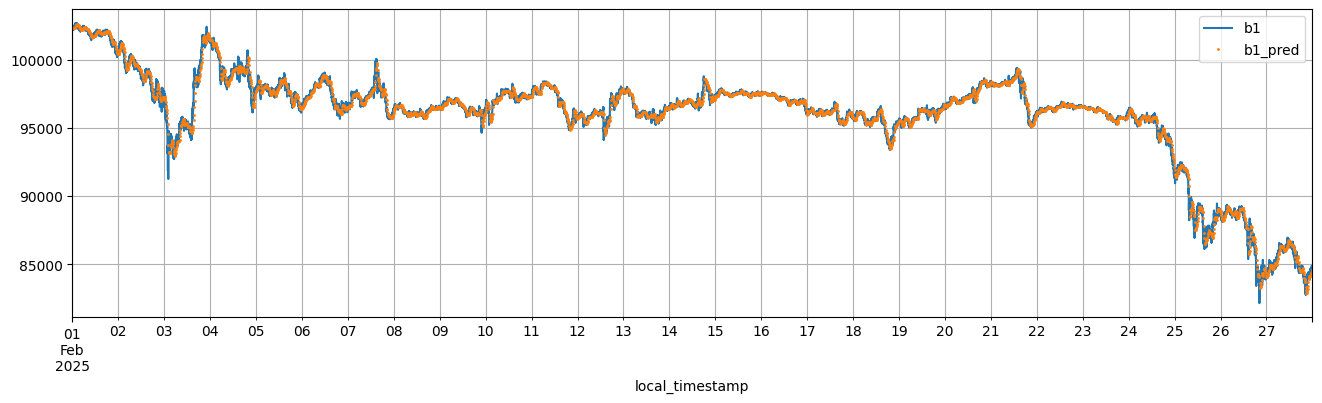

In [12]:
# 予測は基本的に後出しに近い (それはそう)
fig, ax = plt.subplots(figsize=(16, 4))
df_result[["b1"]].plot(ax=ax)
df_result[["b1_pred"]].resample(f"{pred_steps}min").first().shift().plot(ax=ax, ls="", marker=".", ms=2)
# plt.xlim(df_result.index[0], df_result.index[10000])
plt.grid(which="both")

# 手数料・想定手数料を変えてバックテスト

In [13]:
class OrderBot:
    def __init__(self, df_result: pd.DataFrame, model_fee=0.00055):
        self.df = df_result         # b1, a1, b1_pred, a1_pred を含む
        self.model_fee = model_fee  # 「ボットが想定する」手数料．基本的に実際の手数料より多めに見積もるべき

    def order(self, t, state: list) -> tuple[str, int, float]:
        usdt, Q, P, limits = state  # 毎時刻，現在の所持金usdt，建玉数量Q，平均建玉価格P，指値limits情報を得る (実際の取引に似せて)
        # order_type, price: バックテストコードが将来的に指値に対応するためのもの．今回は成行なので適当で構わない
        order_type = "Market"   # Market | Limit
        price = 0               # 成行では何でも良い (ダミー)

        df_t = self.df.loc[t]
        pos = ASK if Q > 0 else BID if Q < 0 else STAY  # 現在のポジション方向

        # 予測値と現在のポジションから期待利益が最大になる行動を決定
        order_t = decide_order(df_t.b1, df_t.a1, df_t.b1_pred, df_t.a1_pred, pos, self.model_fee)[0]
        if order_t == BID:      # 下落予測
            if   Q < 0: qty_x1000 = 0   # 既に売り建玉があれば何もしない
            elif Q > 0: qty_x1000 = -2  # 既に買い建玉があればドテン
            else:       qty_x1000 = -1  # 建玉0なら新規売り
        elif order_t == ASK:    # 上昇予測
            if   Q < 0: qty_x1000 = 2
            elif Q > 0: qty_x1000 = 0
            else:       qty_x1000 = 1
        else:                   # 変化無し予測: 決済のみ
            if   Q < 0: qty_x1000 = 1
            elif Q > 0: qty_x1000 = -1
            else:       qty_x1000 = 0
        return order_type, qty_x1000, price

def validation(df_result: pd.DataFrame, pred_steps=10, fee=0.00055, model_fee=0.00055):
    # バックテスト
    df_steps = df_result.resample(f"{pred_steps}min").first()
    order_func = OrderBot(df_steps, model_fee).order
    df_bt = backtest.backtest(df_result["b1"], df_result["a1"], order_func, df_steps.index[0], df_steps.index[-1], freq=f"{pred_steps}min", fee_market=fee)

    # プロット
    fig, axes = plt.subplots(4, 1, figsize=(16, 8))
    df_bt[["USDT"]].plot(ax=axes[0])    # 資産推移

    # 価格(b1)，予測値，売買
    df_bt[["b1"]].plot(ax=axes[1])
    df_result[["b1_pred"]].resample(f"{pred_steps}min").first().shift().plot(ax=axes[1], ls="", marker=".", ms=2)
    df_bt.loc[df_bt["q"]>0,"a1"].plot(ax=axes[1], ls="", marker="^", ms=1, color="g") if any(df_bt["q"]>0) else None
    df_bt.loc[df_bt["q"]<0,"b1"].plot(ax=axes[1], ls="", marker="v", ms=1, color="r") if any(df_bt["q"]<0) else None
    axes[1].legend(["b1", "b1_pred", "buy", "sell"], loc="lower right")

    # ポジション
    df_bt[["Q", "q"]].plot(ax=axes[2])
    axes[2].legend(["Qty", "ΔQty"])

    # 変分自由エネルギー
    df_result[["VFE", "complexity"]].plot(ax=axes[3], alpha=1)
    # axes[3].set_ylim(0, 1)

    for i in range(4):
        axes[i].grid(which="both")
    # plt.tight_layout()
    return df_bt

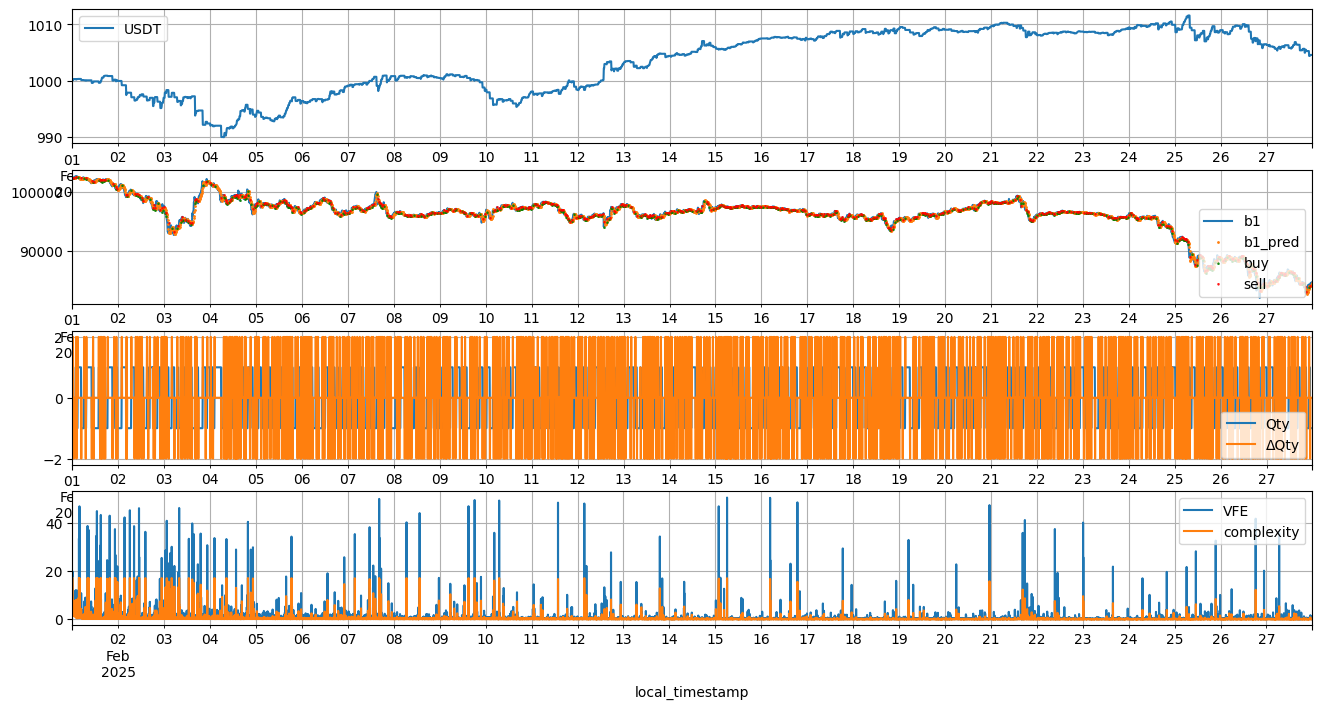

In [14]:
# 手数料0ならかなり安定して増える
df_bt = validation(df_result, pred_steps, fee=0, model_fee=0)

In [15]:
df_bt

,b1,a1,OrderType,q,p,USDT,Q,P
2025-02-01 00:00:00,NaN,NaN,,0,NaN,1000.0000,0,NaN
2025-02-01 00:10:00,102448.8,102448.9,Market,-1,102448.8,1000.0000,-1,102448.8
2025-02-01 00:20:00,102302.1,102302.2,Market,2,102302.2,1000.1466,1,102302.2
2025-02-01 00:30:00,102199.9,102200.0,Market,0,102199.9,1000.1466,1,102302.2
2025-02-01 00:40:00,102414.4,102414.5,Market,-2,102414.4,1000.2588,-1,102414.4
...,...,...,...,...,...,...,...,...
2025-02-27 23:10:00,84414.0,84414.1,Market,0,84414.0,1004.5549,-1,84195.6
2025-02-27 23:20:00,84627.7,84627.8,Market,0,84627.7,1004.5549,-1,84195.6
2025-02-27 23:30:00,84571.4,84571.5,Market,0,84571.4,1004.5549,-1,84195.6
2025-02-27 23:40:00,84808.0,84808.1,Market,0,84808.0,1004.5549,-1,84195.6


In [16]:
df_bt["q"].value_counts()   # 注文数量分布

q
 0    2770
-2     543
 2     540
 1      20
-1      15
Name: count, dtype: int64

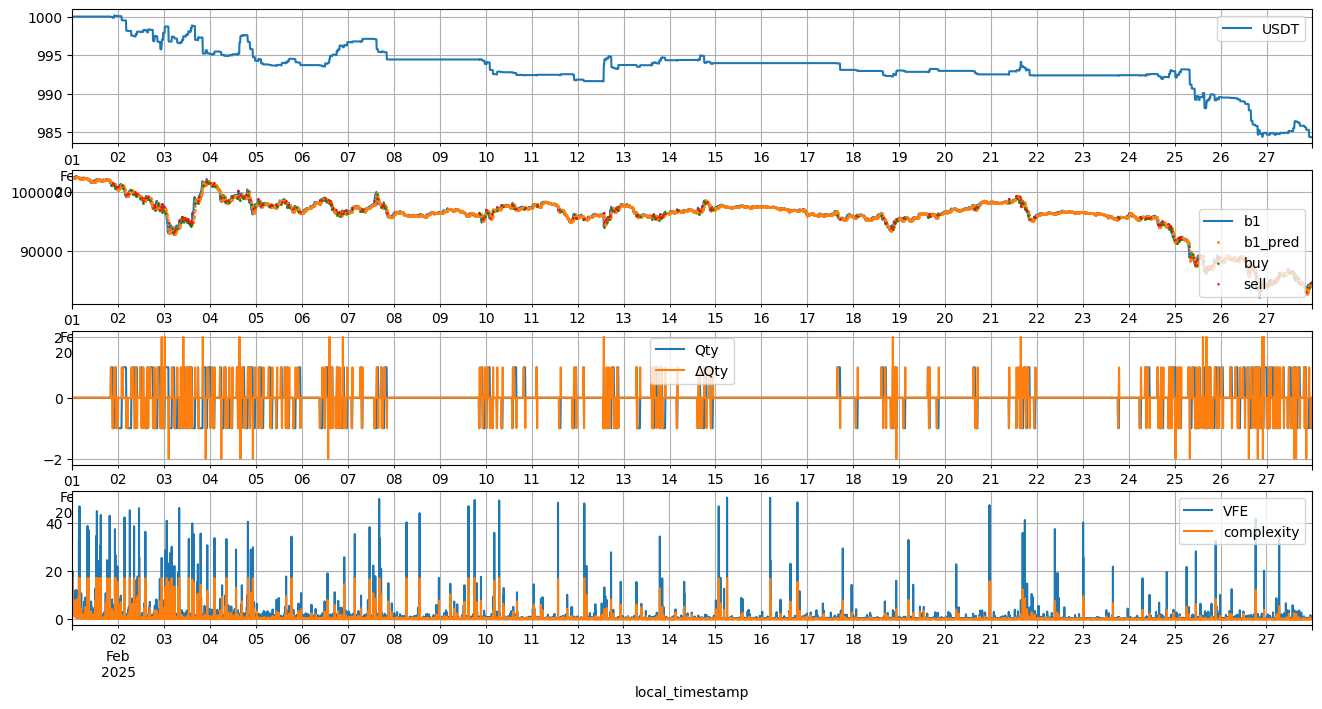

In [17]:
# 手数料ありだと苦しい
df_bt = validation(df_result, pred_steps, fee=0.00055, model_fee=0.0015)